# Data

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import sys
import os
current_dir = os.path.dirname(os.path.abspath("__file__"))
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
if parent_dir not in sys.path:
	sys.path.insert(0, parent_dir)
from src.models.single_pressure.variable_diffusivity_fvt import FVTModel
from src.models.single_pressure.variable_diffusivity_fvt.workflow import manual_workflow
from src.utils.data_processing import preprocess_data
from src.utils.optimisation import OptimisationCallback

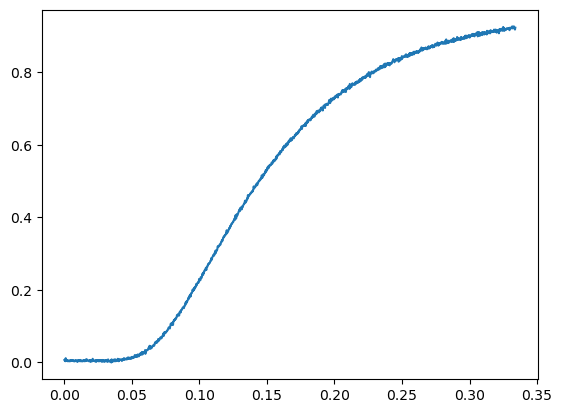

In [2]:
# Load experimental data
data_path = '../data/single_pressure/RUN_H_25C-50bar.xlsx'
exp_data = pd.read_excel(data_path)

model = FVTModel.from_parameters(
        pressure=50,
        temperature=25,
        thickness=0.1,
        diameter=1.0,
        flowrate=8.0,
        DT_0=2.38e-7,
        D1_prime=1.0,   # placeholder
    )
# Preprocess data and calculate tau
processed_exp_data = preprocess_data(
    exp_data,
    thickness=model.params.transport.thickness,
    diameter=model.params.transport.diameter,
    flowrate=model.params.transport.flowrate,
    temperature=model.params.base.temperature,
    stabilisation_threshold=0.005,
    truncate_at_stabilisation=True,
)

# Create 'tau' column
processed_exp_data['tau'] = model.params.transport.DT_0 * processed_exp_data['time'] / model.params.transport.thickness**2

# Downsample to 1000 points for faster optimization
if len(processed_exp_data) > 1000:
    n = len(processed_exp_data) // 1000
    processed_exp_data = processed_exp_data.iloc[::n].reset_index(drop=True)

plt.plot(processed_exp_data['tau'], processed_exp_data['normalised_flux'])
plt.show()

# Methods

## L-BFGS-B

In [25]:
def fit_data_LBFGSB(data, initial_guess=5.0, bounds=(1.01, 100)):
    # Store last objective value for callback
    last_rmse = [float('inf')]
    
    def objective(params):
        D1_prime = params
        _, flux_df = model._solve_pde(
            L=model.params.transport.thickness,
            D1_prime=D1_prime,
            DT_0=model.params.transport.DT_0,
            T=data['time'].max(),
            X=1.0,
            dx=0.005,
        )
        
        # Interpolate model norm flux to data time points
        model_norm_flux = np.interp(data['tau'], flux_df['tau'], flux_df['normalised_flux'])
        
        # Calculate RMSE
        rmse = np.sqrt(np.mean((data['normalised_flux'] - model_norm_flux)**2))
        last_rmse[0] = rmse
        
        return rmse
    
    # Initial guess from current parameters (optimizing D1_prime only; DT_0 remains fixed)
    x0 = [initial_guess]
    bounds = [bounds]
    
    # Optimize
    result = minimize(
        lambda x: objective(x[0]),
        x0=x0,
        method='L-BFGS-B',
        bounds=bounds,
        callback=None,
    )
    
    # Print results
    print(f"Optimization result: {result}")   
    
    return result.x[0], last_rmse[0]

In [26]:
fit_results = fit_data_LBFGSB(processed_exp_data, initial_guess=5.0, bounds=(1.01, 100))
model, Dprime_df, flux_df, figures = manual_workflow(
    pressure=model.params.base.pressure,
    temperature=model.params.base.temperature,
    thickness=model.params.transport.thickness,
    diameter=model.params.transport.diameter,
    flowrate=model.params.transport.flowrate,
    D1_prime=fit_results[0],
    DT_0=model.params.transport.DT_0,
    experimental_data=processed_exp_data,
    simulation_params={
        'T': processed_exp_data['time'].max(),
        'X': 1.0,
        'dx': 0.005,
        },
    output_settings={
            'output_dir': 'outputs/fitting',
            'display_plots': True,
            'save_plots': False,
            'save_data': False,
            'plot_format': 'png',
            'data_format': 'csv'
    }
)


Adaptive PDE Solve (D1'=5.0, DTO=2.38e-07):   0%|                       | 0/44160.0 [00:00<?, ?it/s]

Adaptive PDE Solve (D1'=5.0, DTO=2.38e-07): 44162.868114456105it [00:01, 25934.05it/s]              
Adaptive PDE Solve (D1'=5.00000001, DTO=2.38e-07): 44162.868114456105it [00:01, 27896.60it/s]       
Adaptive PDE Solve (D1'=4.98018960350072, DTO=2.38e-07): 44167.8586819049it [00:01, 27910.97it/s]   
Adaptive PDE Solve (D1'=4.98018961350072, DTO=2.38e-07):  25%|▎| 11159.554674475145/44160.0 [00:01<0

KeyboardInterrupt: 

## L-BFGS-B with multi-start

In [31]:
def fit_data_LBFGSB_multistarts(data, initial_guess=5.0, bounds=(1.01, 100), n_starts=5):
    """
    Multi-start optimization for fitting D1_prime using L-BFGS-B.
    
    Parameters:
      data : dict
          Experimental data with keys 'time', 'tau', and 'norm_flux'.
      initial_guess : float
          Default initial value for D1_prime.
      bounds : tuple
          Lower and upper bound for D1_prime.
      n_starts : int
          Number of starting points to try.
    
    Returns:
      best_params : dict
          Dictionary containing the best fit parameters and RMSE.
          Example: {'D1_prime': value, 'rmse': value, 'optimisation_result': result}
    """
    best_result = None
    best_fun = np.inf
    best_rmse = np.inf

    def objective(params):
        D1_prime = params
        # Assuming 'model' is accessible from the current context
        _, flux_df = model._solve_pde(
            L=model.params.transport.thickness,
            D1_prime=D1_prime,
            DT_0=model.params.transport.DT_0,
            T=data['time'].max(),
            X=1.0,
            dx=0.005,
        )
        # Interpolate model normalized flux to data tau points
        model_norm_flux = np.interp(data['tau'], flux_df['tau'], flux_df['normalised_flux'])
        rmse = np.sqrt(np.mean((data['normalised_flux'] - model_norm_flux) ** 2))
        return rmse

    # Prepare bounds in required format: [(low, high)]
    bounds_list = [bounds]
    
    for i in range(n_starts):
        # Use the provided initial guess for the first start; for subsequent starts use a random candidate within bounds.
        if i == 0:
            x0 = [initial_guess]
        else:
            low, high = bounds
            candidate = np.random.uniform(low, high)
            x0 = [candidate]
        result = minimize(
            lambda x: objective(x[0]),
            x0=x0,
            method='L-BFGS-B',
            bounds=bounds_list,
            callback=None
        )
        if result.fun < best_fun:
            best_fun = result.fun
            best_result = result
            best_rmse = result.fun
    
    print(f"Best optimization result: {best_result}")
    best_params = {
        'D1_prime': best_result.x[0],
        'rmse': best_rmse,
        'optimisation_result': best_result
    }
    return best_params


















Adaptive PDE Solve (D1'=5.0, DTO=2.38e-07): 44162.868114456105it [00:01, 27734.35it/s]              
















Adaptive PDE Solve (D1'=5.00000001, DTO=2.38e-07): 44162.868114456105it [00:01, 25329.35it/s]       
















Adaptive PDE Solve (D1'=4.98018960350072, DTO=2.38e-07): 44167.8586819049it [00:01, 28022.48it/s]   
















Adaptive PDE Solve (D1'=4.98018961350072, DTO=2.38e-07): 44167.8586819049it [00:01, 27934.53it/s]   
















Adaptive PDE Solve (D1'=4.960304815119444, DTO=2.38e-07): 44169.452646729886it [00:01, 27784.08it/s]
















Adaptive PDE Solve (D1'=4.960304825119444, DTO=2.38e-07): 44169.452646729886it [00:01, 27756.20it/s]
















Adaptive PDE Solve (D1'=4.8807656615943396, DTO=2.38e-07): 44161.59198703404it [00:01, 25652.47it/s]
















Adaptive PDE Solve (D1'=4.8807656715943395, DTO=2.38e-07): 44161.59198703404it [00:01, 28519.34it/s]















Adaptive PDE Solve (D1'=4.562609047493923, DTO=2.

Best optimization result:   message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.015090566244238914
        x: [ 1.183e+00]
      nit: 6
      jac: [-5.176e-03]
     nfev: 114
     njev: 57
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>








Adaptive PDE Solve (D1'=1.1833057810305825, DTO=2.38e-07): 44169.15560370677it [00:00, 84018.24it/s]
Adaptive PDE Solve (D1'=4.98018961350072, DTO=2.38e-07):  29%|▎| 12747.06445555994/44160.0 [22:34<55


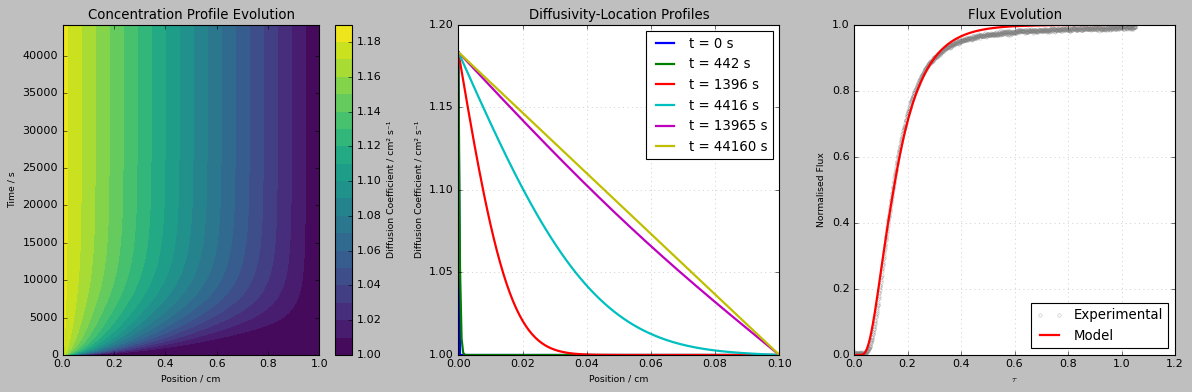

In [33]:
# Example usage:
fit_results = fit_data_LBFGSB_multistarts(processed_exp_data, initial_guess=5.0, bounds=(1.001, 100), n_starts=3)
model, Dprime_df, flux_df, figures = manual_workflow(
    pressure=model.params.base.pressure,
    temperature=model.params.base.temperature,
    thickness=model.params.transport.thickness,
    diameter=model.params.transport.diameter,
    flowrate=model.params.transport.flowrate,
    D1_prime=fit_results['D1_prime'],
    DT_0=model.params.transport.DT_0,
    experimental_data=processed_exp_data,
    simulation_params={
        'T': processed_exp_data['time'].max(),
        'X': 1.0,
        'dx': 0.005,
        },
    output_settings={
            'output_dir': 'outputs/fitting',
            'display_plots': True,
            'save_plots': False,
            'save_data': False,
            'plot_format': 'png',
            'data_format': 'csv'
    }
)


## L-BFGS-B with multi-start and callback

### D1'

In [4]:
def fit_data_LBFGSB_multistarts_callback(data, initial_guess=5.0, bounds=(1.01, 100), n_starts=1):
    """
    Multi-start optimization for fitting D1_prime using L-BFGS-B.
    
    Parameters:
      data : dict
          Experimental data with keys 'time', 'tau', and 'norm_flux'.
      initial_guess : float
          Default initial value for D1_prime.
      bounds : tuple
          Lower and upper bound for D1_prime.
      n_starts : int
          Number of starting points to try.
    
    Returns:
      best_params : dict
          Dictionary containing the best fit parameters and RMSE.
          Example: {'D1_prime': value, 'rmse': value, 'optimisation_result': result}
    """
    # Validate that n_starts is an integer greater than or equal to 1
    if not isinstance(n_starts, int) or n_starts < 1:
        raise ValueError("n_starts must be an integer greater than or equal to 1")
    
    best_result = None
    best_fun = np.inf
    best_rmse = np.inf

    # Create a common callback instance (it will collect history over all multi-start runs)
    callback_instance = OptimisationCallback(param_names=["D1_prime"])
    
    # Global variable to hold the last RMSE calculated by objective
    last_rmse = [float('inf')]
    
    def objective(params):
        D1_prime = params
        # Assuming 'model' is accessible from the current context
        _, flux_df = model._solve_pde(
            L=model.params.transport.thickness,
            D1_prime=D1_prime,
            DT_0=model.params.transport.DT_0,
            T=data['time'].max(),
            X=1.0,
            dx=0.005,
            track_solving_progress=False
        )
        # Interpolate model normalized flux to data tau points
        model_norm_flux = np.interp(data['tau'], flux_df['tau'], flux_df['normalised_flux'])
        rmse = np.sqrt(np.mean((data['normalised_flux'] - model_norm_flux) ** 2))
        last_rmse[0] = rmse
        return rmse

    # Prepare bounds in required format: [(low, high)]
    bounds_list = [bounds]
    
    for i in range(n_starts):
        # Use the provided initial guess for the first start; for subsequent starts use a random candidate within bounds.
        if i == 0:
            x0 = [initial_guess]
        else:
            low, high = bounds
            candidate = np.random.uniform(low, high)
            x0 = [candidate]
        
        # Define a local callback that sends the current parameter vector and last RMSE to our callback_instance.
        def local_callback(xk):
            # SciPy's callback receives xk only.
            # Pass current xk and the last computed rmse.
            callback_instance(xk, last_rmse[0])
        
        # Run minimization with L-BFGS-B for this starting point
        result = minimize(
            lambda x: objective(x[0]),
            x0=x0,
            method='L-BFGS-B',
            bounds=bounds_list,
            callback=local_callback
        )
        
        if result.fun < best_fun:
            best_fun = result.fun
            best_result = result
            best_rmse = result.fun
    
    callback_instance.close()

    best_params = {
        'D1_prime': best_result.x[0],
        'rmse': best_rmse,
        'optimisation_result': best_result,
        'optimisation_history': callback_instance.history
    }
    print(f"Best optimization result: {best_result}")
    
    return best_params

Fitting (multi-start): 0iter [00:00, ?iter/s]

Best optimization result:   message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.014164390772117511
        x: [ 1.133e+00]
      nit: 8
      jac: [ 5.295e+03]
     nfev: 134
     njev: 67
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>


Adaptive PDE Solve (D1'=1.1328002422146504, DTO=2.38e-07): 14036.1830382892it [00:00, 40931.07it/s] 


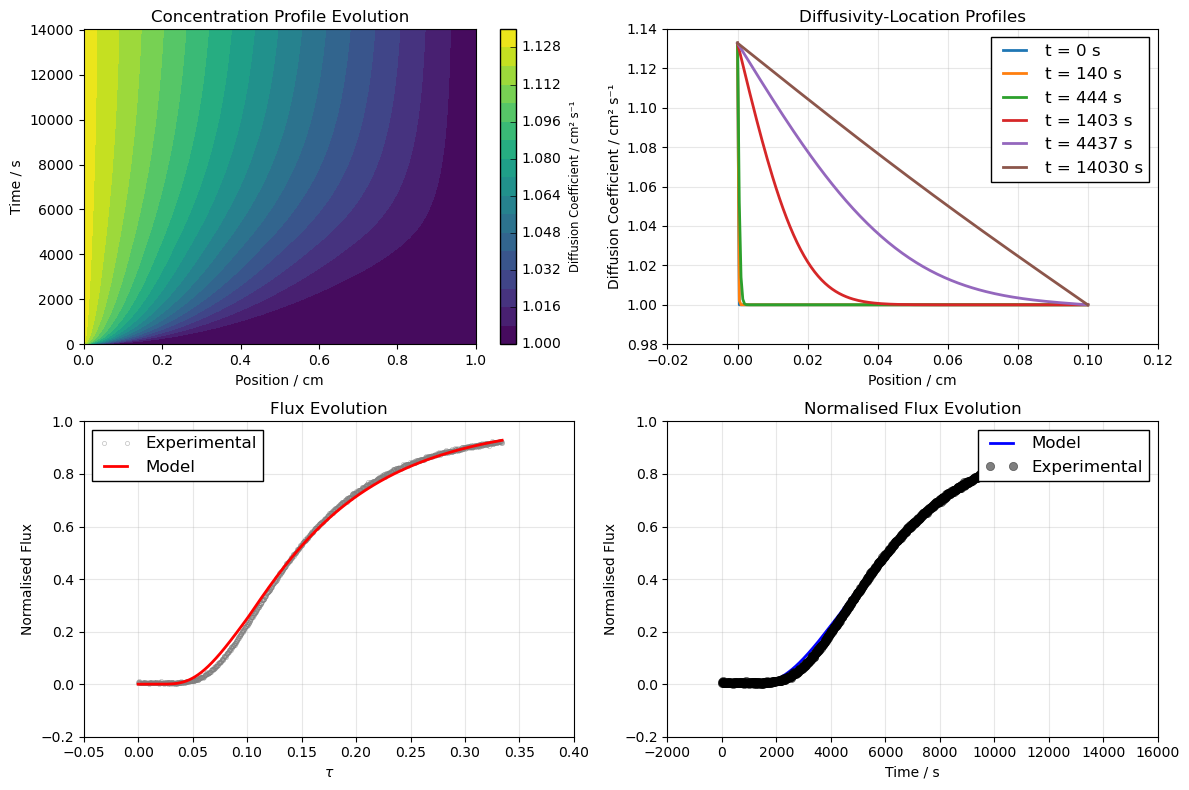

In [5]:
# Example usage:
fit_results = fit_data_LBFGSB_multistarts_callback(processed_exp_data, initial_guess=5.0, bounds=(1.001, 20), n_starts=2)
model, Dprime_df, flux_df, figures = manual_workflow(
    pressure=model.params.base.pressure,
    temperature=model.params.base.temperature,
    thickness=model.params.transport.thickness,
    diameter=model.params.transport.diameter,
    flowrate=model.params.transport.flowrate,
    D1_prime=fit_results['D1_prime'],
    DT_0=model.params.transport.DT_0,
    experimental_data=processed_exp_data,
    simulation_params={
        'T': processed_exp_data['time'].max(),
        'X': 1.0,
        'dx': 0.005,
        },
    output_settings={
            'output_dir': 'outputs/fitting',
            'display_plots': True,
            'save_plots': False,
            'save_data': False,
            'plot_format': 'png',
            'data_format': 'csv'
    }
)

### D1' and DT0

#### Normal

In [3]:
def fit_data_LBFGSB_multistarts_callback_2(data, initial_guess=5.0, bounds=(1.01, 100), n_starts=1):
    """
    Multi-start optimization for fitting D1_prime and DT_0 using L-BFGS-B with callback tracking.
    
    Parameters:
      data : dict
          Experimental data with keys 'time', 'tau', and 'norm_flux'.
      initial_guess : tuple of floats
          Default initial values for (D1_prime, DT_0).
      bounds : tuple of tuples
          Bounds for D1_prime and DT_0, e.g. ((low_D1, high_D1), (low_DT0, high_DT0)).
      n_starts : int
          Number of starting points to try.
    
    Returns:
      best_params : dict
          Dictionary containing the best-fit parameters, RMSE, the full optimization result,
          and the callback history.
          Example: {'D1_prime': value, 'DT_0': value, 'rmse': value, ... }
    """
    # Validate that n_starts is an integer greater than or equal to 1
    if not isinstance(n_starts, int) or n_starts < 1:
        raise ValueError("n_starts must be an integer greater than or equal to 1")
    
    best_result = None
    best_fun = np.inf
    best_rmse = np.inf

    # Create a common callback instance (it will collect history over all multi-start runs)
    callback_instance = OptimisationCallback(param_names=["D1_prime", "DT_0"])
    
    # Global variable to hold the last RMSE calculated by objective
    last_rmse = [float('inf')]
    
    def objective(params):
        D1_prime, DT_0 = params
        # Assuming 'model' is accessible from the current context
        _, flux_df = model._solve_pde(
            L=model.params.transport.thickness,
            D1_prime=D1_prime,
            DT_0=DT_0,
            T=data['time'].max(),
            X=1.0,
            dx=0.005,
        )
        # Interpolate model normalized flux to data tau points
        model_norm_flux = np.interp(data['time'], flux_df['time'], flux_df['normalised_flux'])
        rmse = np.sqrt(np.mean((data['normalised_flux'] - model_norm_flux) ** 2))
        last_rmse[0] = rmse
        return rmse

    # Prepare bounds in required format: a list of tuples
    bounds_list = list(bounds)
    
    for i in range(n_starts):
        # Use the provided initial guess for the first start; for subsequent starts use a random candidate within bounds.
        if i == 0:
            x0 = list(initial_guess)    # list
        else:
            candidate = [np.random.uniform(low, high) for (low, high) in bounds_list]
            x0 = candidate  # list
        
            # Define a local callback that sends the current parameter vector and last RMSE to our callback_instance.
        def local_callback(xk):
            # SciPy's callback receives xk only.
            # Pass current xk and the last computed rmse.
            callback_instance(xk, last_rmse[0])
        
        # Run minimization with L-BFGS-B for this starting point
        result = minimize(
            lambda x: objective(x),
            x0=x0,
            method='L-BFGS-B',
            bounds=bounds_list,
            callback=local_callback
        )
        
        if result.fun < best_fun:
            best_fun = result.fun
            best_result = result
            best_rmse = result.fun
    
    callback_instance.close()

    best_params = {
        'D1_prime': best_result.x[0],
        'DT_0': best_result.x[1],
        'rmse': best_rmse,
        'optimisation_result': best_result,
        'optimisation_history': callback_instance.history
    }
    print(f"Best optimization result:")
    print(best_params)
    
    return best_params

Fitting (multi-start): 0iter [00:00, ?iter/s]

Adaptive PDE Solve (D1'=5.0, DTO=1e-07): 44162.46753516588it [00:02, 21904.34it/s]                  
Adaptive PDE Solve (D1'=5.00000001, DTO=1e-07): 44162.46753516588it [00:01, 29486.03it/s]           
Adaptive PDE Solve (D1'=5.0, DTO=1.0999999999999999e-07): 44161.439383547404it [00:01, 33367.26it/s]
Adaptive PDE Solve (D1'=5.0003771390195215, DTO=1e-06): 44167.10994145788it [00:02, 21008.25it/s]   
Adaptive PDE Solve (D1'=5.0003771490195215, DTO=1e-06): 44167.10994145788it [00:02, 21077.95it/s]   
Adaptive PDE Solve (D1'=5.0003771390195215, DTO=9.9e-07): 44163.42094283127it [00:02, 19379.10it/s] 
Adaptive PDE Solve (D1'=5.000114192362101, DTO=3.7250727336906417e-07): 44163.12779886047it [00:01, 25082.48it/s]
Adaptive PDE Solve (D1'=5.000114202362101, DTO=3.7250727336906417e-07): 44163.12779886047it [00:01, 25649.01it/s]
Adaptive PDE Solve (D1'=5.000114192362101, DTO=3.825072733690642e-07): 44165.10094524713it [00:01, 23048.71it/s]
Adaptive PDE Solve (D1'=5.000035073911279, DTO=1.8369

Best optimization result:
{'D1_prime': 5.000021748440508, 'DT_0': 1.5190032291492153e-07, 'rmse': 0.027295479597978643, 'optimisation_result':   message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: 0.027295479597978643
        x: [ 5.000e+00  1.519e-07]
      nit: 4
      jac: [ 3.473e-03  5.377e+05]
     nfev: 150
     njev: 50
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>, 'optimisation_history': [{'iteration': 0, 'D1_prime': 5.000035073911279, 'DT_0': 1.8369995815290932e-07, 'rmse': 0.07190859568381006}, {'iteration': 1, 'D1_prime': 5.000025066929934, 'DT_0': 1.5981956997041408e-07, 'rmse': 0.04158350174993429}, {'iteration': 2, 'D1_prime': 5.00002258960002, 'DT_0': 1.5390767150203558e-07, 'rmse': 0.03471559684645483}, {'iteration': 3, 'D1_prime': 5.000021748440508, 'DT_0': 1.5190032291492153e-07, 'rmse': 0.03267259966675512}]}


Adaptive PDE Solve (D1'=5.000021748440508, DTO=1.5190032291492153e-07): 44167.24540316226it [00:01, 31415.45it/s]


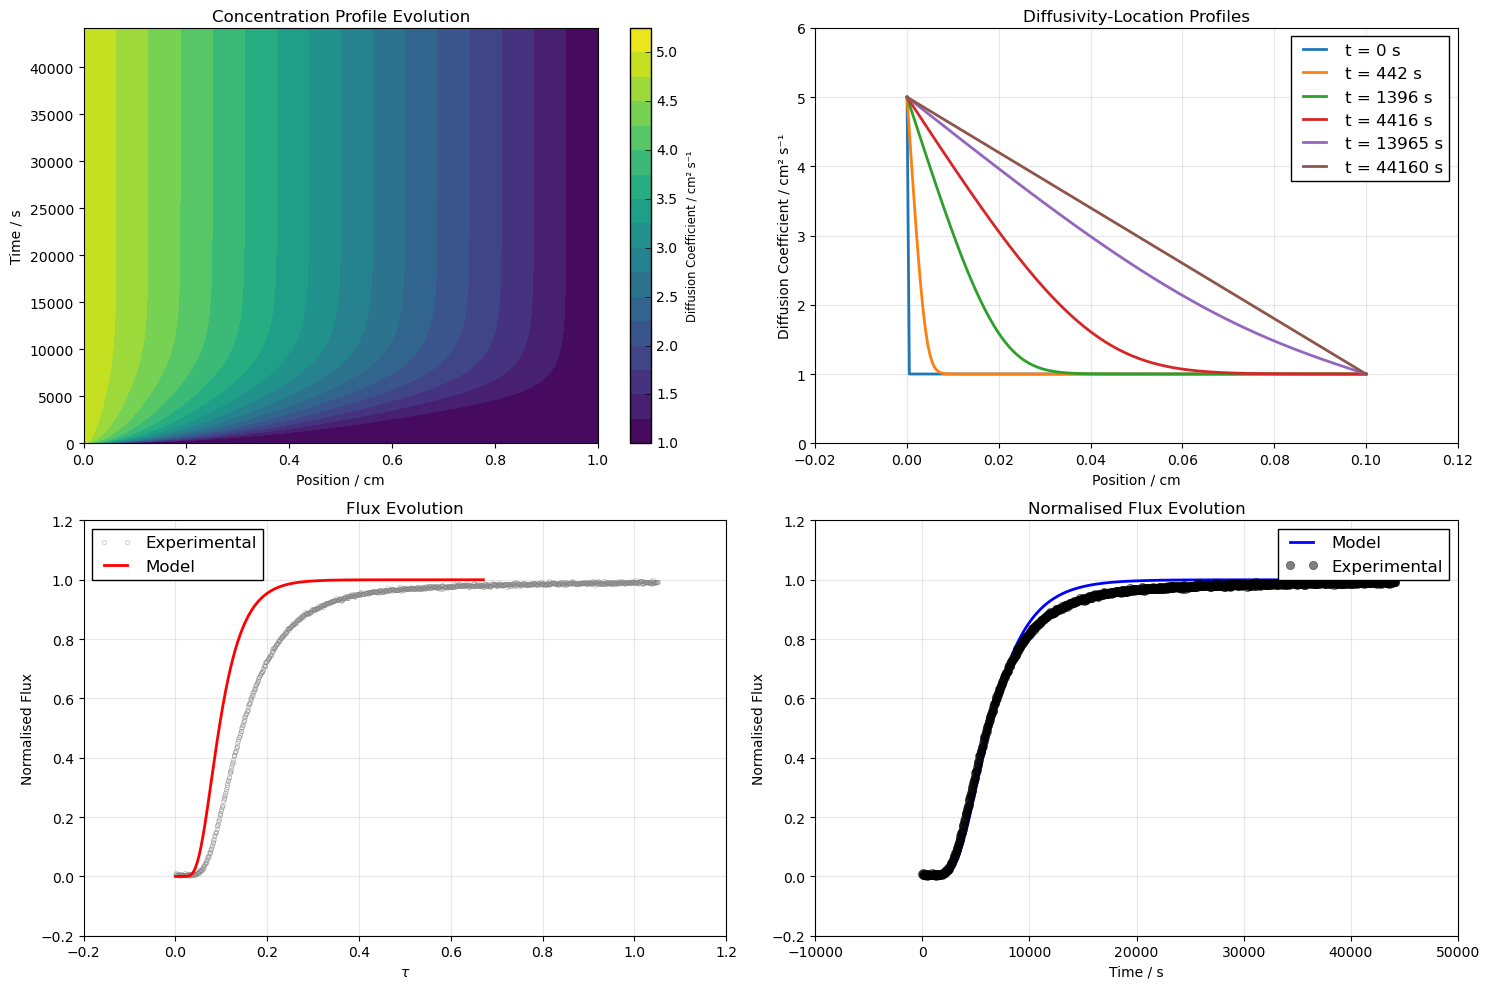

In [4]:
# Example usage:
fit_results = fit_data_LBFGSB_multistarts_callback_2(processed_exp_data, 
                                                     initial_guess=(5.0, 1.0e-7), 
                                                     bounds=((1.001, 20), (1e-8, 1e-6)), 
                                                     n_starts=1)
model, Dprime_df, flux_df, figures = manual_workflow(
    pressure=model.params.base.pressure,
    temperature=model.params.base.temperature,
    thickness=model.params.transport.thickness,
    diameter=model.params.transport.diameter,
    flowrate=model.params.transport.flowrate,
    D1_prime=fit_results['D1_prime'],
    DT_0=fit_results['DT_0'],
    experimental_data=processed_exp_data,
    simulation_params={
        'T': processed_exp_data['time'].max(),
        'X': 1.0,
        'dx': 0.005,
        },
    output_settings={
            'output_dir': 'outputs/fitting',
            'display_plots': True,
            'save_plots': False,
            'save_data': False,
            'plot_format': 'png',
            'data_format': 'csv'
    }
)

#### Scaled

In [8]:
def fit_data_LBFGSB_multistarts_scaled(data, initial_guess=(5.0, 1e-7), bounds=((1.001, 20), (1e-8, 1e-6)), n_starts=2):
    """
    Optimization with parameter scaling to handle different magnitude parameters.
    """
    # Define scaling factors based on typical parameter magnitudes
    scale_factors = [1.0, 1e7]  # Makes both parameters ~O(1)
    
    # Scale initial guess and bounds
    scaled_initial = [ig/sf for ig, sf in zip(initial_guess, scale_factors)]
    scaled_bounds = [tuple(b/sf for b in bnd) for bnd, sf in zip(bounds, scale_factors)]
    
    last_rmse = [float('inf')]
    callback = OptimisationCallback(param_names=["D1_prime", "DT_0"])
    
    def objective(scaled_params):
        # Unscale parameters for model evaluation
        params = [sp*sf for sp, sf in zip(scaled_params, scale_factors)]
        D1_prime, DT_0 = params
        
        _, flux_df = model._solve_pde(
            L=model.params.transport.thickness,
            D1_prime=D1_prime,
            DT_0=DT_0,
            T=data['time'].max(),
            X=1.0,
            dx=0.005,
            track_solving_progress=True
        )
        model_norm_flux = np.interp(data['time'], flux_df['time'], flux_df['normalised_flux'])
        rmse = np.sqrt(np.mean((data['normalised_flux'] - model_norm_flux) ** 2))
        last_rmse[0] = rmse
        return rmse
    
    def local_callback(xk):
        # Unscale parameters for callback display
        unscaled_xk = [x*sf for x, sf in zip(xk, scale_factors)]
        callback(unscaled_xk, last_rmse[0])

    best_result = None
    best_rmse = np.inf
    
    for i in range(n_starts):
        if i == 0:
            x0 = scaled_initial
        else:
            x0 = [np.random.uniform(low, high) for (low, high) in scaled_bounds]
        
        result = minimize(
            objective,
            x0=x0,
            method='L-BFGS-B',
            bounds=scaled_bounds,
            callback=local_callback,
            options={
                'ftol': 1e-8,
                'maxiter': 100,
                'maxfun': 200
            }
        )
        
        if result.fun < best_rmse:
            best_rmse = result.fun
            best_result = result
    
    # Unscale the final results
    unscaled_x = [x*sf for x, sf in zip(best_result.x, scale_factors)]
    
    callback.close()
    return {
        'D1_prime': unscaled_x[0],
        'DT_0': unscaled_x[1],
        'rmse': best_rmse,
        'optimisation_result': best_result,
        'optimisation_history': callback.history
    }

Fitting (multi-start): 0iter [00:00, ?iter/s]

Adaptive PDE Solve (D1'=2.0, DTO=1e-07): 14030.87547263367it [00:00, 48161.43it/s]                  
Adaptive PDE Solve (D1'=2.00000001, DTO=1e-07): 14030.87547263367it [00:00, 53805.44it/s]           
Adaptive PDE Solve (D1'=2.0, DTO=1e-06): 14032.80798501872it [00:01, 10852.58it/s]                  
Adaptive PDE Solve (D1'=2.0000000000015175, DTO=1e-08): 14030.87547263367it [00:00, 271243.29it/s]  
Adaptive PDE Solve (D1'=2.0000000100015174, DTO=1e-08): 14030.87547263367it [00:00, 287520.80it/s]  
Adaptive PDE Solve (D1'=2.0000000000015175, DTO=1e-06): 14032.80798501872it [00:01, 10877.32it/s]   
Adaptive PDE Solve (D1'=2.000000000000012, DTO=9.927989993719449e-08): 14030.87547263367it [00:00, 45582.72it/s]
Adaptive PDE Solve (D1'=2.000000010000012, DTO=9.927989993719449e-08): 14030.87547263367it [00:00, 54221.97it/s]
Adaptive PDE Solve (D1'=2.000000000000012, DTO=1e-06): 14032.80798501872it [00:01, 10868.54it/s]    
Adaptive PDE Solve (D1'=2.0, DTO=9.999634373590644e-08): 14030.8754

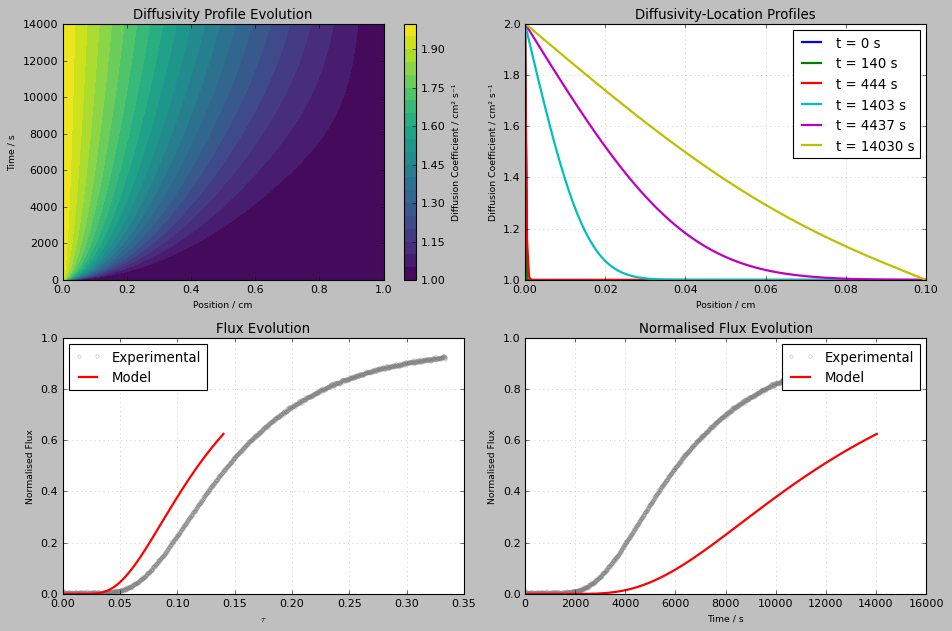

In [10]:
# Example usage:
fit_results = fit_data_LBFGSB_multistarts_scaled(processed_exp_data, 
                                                     initial_guess=(2.0, 1.0e-7), 
                                                     bounds=((1.001, 20), (1e-8, 1e-6)), 
                                                     n_starts=1)
model, Dprime_df, flux_df, figures = manual_workflow(
    pressure=model.params.base.pressure,
    temperature=model.params.base.temperature,
    thickness=model.params.transport.thickness,
    diameter=model.params.transport.diameter,
    flowrate=model.params.transport.flowrate,
    D1_prime=fit_results['D1_prime'],
    DT_0=fit_results['DT_0'],
    experimental_data=processed_exp_data,
    simulation_params={
        'T': processed_exp_data['time'].max(),
        'X': 1.0,
        'dx': 0.005,
        },
    output_settings={
            'output_dir': 'outputs/fitting',
            'display_plots': True,
            'save_plots': False,
            'save_data': False,
            'plot_format': 'png',
            'data_format': 'csv'
    }
)

#### Adaptive scaling

Key changes:

1. `calculate_adaptive_scaling` computes scaling factors based on parameter magnitudes
2. Scaling factors are recalculated for each multi-start iteration
3. Each iteration uses its own scaled parameters and bounds
4. Best scaling factors are stored with best result for final unscaling
5. Objective function and callback use iteration-specific scaling factors

This approach allows the optimization to adapt its scaling based on the current region of parameter space being explored in each multi-start iteration.

In [3]:
def calculate_adaptive_scaling(params):
    """
    Calculate adaptive scaling factors based on current parameter values.
    
    Parameters
    ----------
    params : tuple or list
        (D1_prime, DT_0) current values
    
    Returns
    -------
    list
        Scaling factors that bring parameters to ~O(1)
    """
    return [10.0**np.floor(np.log10(abs(p))) for p in params]

def fit_data_LBFGSB_multistarts_adaptive(data, 
                                        initial_guess=(5.0, 1e-7), 
                                        bounds=((1.001, 20), (1e-8, 1e-6)), 
                                        n_starts=5):
    """
    Optimization with scaling that adapts for each multi-start iteration.
    """
    best_result = None
    best_rmse = np.inf
    callback = OptimisationCallback(param_names=["D1_prime", "DT_0"])
    
    for i in range(n_starts):
        # Generate starting point for this iteration
        if i == 0:
            current_guess = initial_guess
        else:
            current_guess = (
                np.random.uniform(bounds[0][0], bounds[0][1]),
                np.random.uniform(bounds[1][0], bounds[1][1])
            )
        
        # Calculate adaptive scaling for this iteration
        scale_factors = calculate_adaptive_scaling(current_guess)
        scaled_initial = [p/sf for p, sf in zip(current_guess, scale_factors)]
        scaled_bounds = [tuple(b/sf for b in bnd) for bnd, sf in zip(bounds, scale_factors)]
        
        last_rmse = [float('inf')]
        
        def objective(scaled_params):
            # Unscale parameters for model evaluation
            params = [sp*sf for sp, sf in zip(scaled_params, scale_factors)]
            D1_prime, DT_0 = params
            
            _, flux_df = model._solve_pde(
                L=model.params.transport.thickness,
                D1_prime=D1_prime,
                DT_0=DT_0,
                T=data['time'].max(),
                X=1.0,
                dx=0.005,
            )
            
            model_norm_flux = np.interp(data['time'], flux_df['time'], flux_df['normalised_flux'])
            rmse = np.sqrt(np.mean((data['normalised_flux'] - model_norm_flux) ** 2))
            last_rmse[0] = rmse
            
            return rmse
        
        def local_callback(xk):
            unscaled_xk = [x*sf for x, sf in zip(xk, scale_factors)]
            callback(unscaled_xk, last_rmse[0])
        
        result = minimize(
            objective,
            x0=scaled_initial,
            method='L-BFGS-B',
            bounds=scaled_bounds,
            callback=local_callback,
            options={
                'ftol': 1e-12,
                'gtol': 1e-12,
                'eps': 1e-8,
                'maxiter': 1000,
                'maxfun': 2000,
                'maxcor': 50
            }
        )
        
        if result.fun < best_rmse:
            best_rmse = result.fun
            best_result = result
            best_scale_factors = scale_factors  # Store successful scaling factors
    
    # Unscale final results using the scaling factors from best result
    unscaled_x = [x*sf for x, sf in zip(best_result.x, best_scale_factors)]
    
    callback.close()
    return {
        'D1_prime': unscaled_x[0],
        'DT_0': unscaled_x[1],
        'rmse': best_rmse,
        'optimisation_result': best_result,
        'optimisation_history': callback.history
    }

Fitting (multi-start): 0iter [00:00, ?iter/s]

Adaptive PDE Solve (D1'=2.0, DTO=1e-07): 14030.87547263367it [00:00, 42289.49it/s]                  
Adaptive PDE Solve (D1'=2.00000001, DTO=1e-07): 14030.87547263367it [00:00, 54234.16it/s]           
Adaptive PDE Solve (D1'=2.0, DTO=1.0000000099999999e-07): 14030.87547263367it [00:00, 52519.10it/s] 
Adaptive PDE Solve (D1'=2.056216887042978, DTO=1.4795653792135516e-07): 14035.348355856482it [00:00, 30798.91it/s]
Adaptive PDE Solve (D1'=2.0562168970429777, DTO=1.4795653792135516e-07): 14035.348355856482it [00:00, 31721.46it/s]
Adaptive PDE Solve (D1'=2.056216887042978, DTO=1.4795653892135516e-07): 14035.348355856482it [00:00, 32970.71it/s]
Adaptive PDE Solve (D1'=2.6308090666957433, DTO=2.920061023821256e-07): 14030.596491460885it [00:01, 13974.09it/s]
Adaptive PDE Solve (D1'=2.6308090766957433, DTO=2.920061023821256e-07): 14030.596491460885it [00:01, 14021.47it/s]
Adaptive PDE Solve (D1'=2.6308090666957433, DTO=2.920061033821256e-07): 14030.596491460885it [00:01, 13816.23it/s]
Adapti

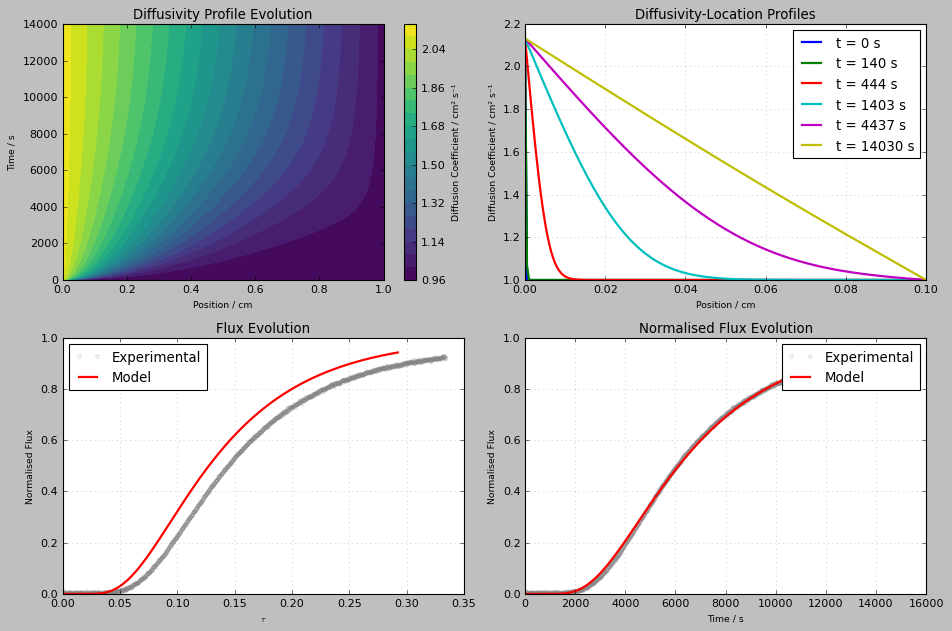

In [14]:
# Example usage:
fit_results = fit_data_LBFGSB_multistarts_adaptive(processed_exp_data, 
                                                     initial_guess=(2.0, 1.0e-7), 
                                                     bounds=((1.001, 20), (1e-8, 1e-6)), 
                                                     n_starts=3)

print(fit_results)
model, Dprime_df, flux_df, figures = manual_workflow(
    pressure=model.params.base.pressure,
    temperature=model.params.base.temperature,
    thickness=model.params.transport.thickness,
    diameter=model.params.transport.diameter,
    flowrate=model.params.transport.flowrate,
    D1_prime=fit_results['D1_prime'],
    DT_0=fit_results['DT_0'],
    experimental_data=processed_exp_data,
    simulation_params={
        'T': processed_exp_data['time'].max(),
        'X': 1.0,
        'dx': 0.005,
        },
    output_settings={
            'output_dir': 'outputs/fitting',
            'display_plots': True,
            'save_plots': False,
            'save_data': False,
            'plot_format': 'png',
            'data_format': 'csv'
    }
)

In [19]:
print(*fit_results['optimisation_history'])

{'iteration': 0, 'D1_prime': 2.056216887042978, 'DT_0': 1.4795653792135516e-07, 'rmse': 0.1814467880151376} {'iteration': 1, 'D1_prime': 2.2881087738411554, 'DT_0': 2.0609155346481466e-07, 'rmse': 0.011160140437944286} {'iteration': 2, 'D1_prime': 2.277282933782253, 'DT_0': 2.0391848023514853e-07, 'rmse': 0.009538404672961255} {'iteration': 3, 'D1_prime': 2.276179777558013, 'DT_0': 2.0404553431361186e-07, 'rmse': 0.00953049935429319} {'iteration': 4, 'D1_prime': 2.2719371795536842, 'DT_0': 2.0424846455774066e-07, 'rmse': 0.009515606676890569} {'iteration': 5, 'D1_prime': 2.2495650564365306, 'DT_0': 2.0508268215520425e-07, 'rmse': 0.009456607830417556} {'iteration': 6, 'D1_prime': 2.205737685226457, 'DT_0': 2.0648215575210365e-07, 'rmse': 0.009364332750684146} {'iteration': 7, 'D1_prime': 2.1407018763359784, 'DT_0': 2.0832552764714486e-07, 'rmse': 0.00926524941423972} {'iteration': 8, 'D1_prime': 2.1215329101653797, 'DT_0': 2.0870923518628181e-07, 'rmse': 0.009237795269255028} {'iterati

#### Adaptive scaling with exploration-exploration

Key improvements:

**Exploration vs Exploitation Balance**:
- Early iterations favor exploration (random sampling)
- Later iterations can exploit successful regions
- Controlled by exploitation_weight parameter

**Adaptive Sampling**:
- Exploration: Completely random within bounds
- Exploitation: Sample near successful previous results
- 10% perturbation of parameter range for local exploration

**Success Tracking**:
- Stores successful optimization results
- Uses them to guide future sampling
- Returns count of successful optimizations

**Adaptive scaling** is key important to help convergence during parameter fitting.

In [5]:
def calculate_adaptive_scaling(params):
    """
    Calculate adaptive scaling factors based on current parameter values.
    """
    return [10.0**np.floor(np.log10(abs(p))) for p in params]

def fit_data_LBFGSB_multistarts_adaptive(data, 
                                        initial_guess=(5.0, 1e-7), 
                                        bounds=((1.001, 20), (1e-8, 1e-6)), 
                                        n_starts=5,
                                        exploitation_weight=0.7, 
                                        minimisation_options=None):
    """
    Optimization with balanced exploration and exploitation.
    
    Parameters
    ----------
    data : pd.DataFrame
        Experimental data with 'time' and 'normalised_flux' columns
    initial_guess : tuple
        Initial (D1_prime, DT_0) values
    bounds : tuple of tuples
        ((D1_min, D1_max), (DT0_min, DT0_max))
    n_starts : int
        Number of multi-starts
    exploitation_weight : float
        Balance between exploitation (1.0) and exploration (0.0)
    """
    best_result = None
    best_rmse = np.inf
    callback = OptimisationCallback(param_names=["D1_prime", "DT_0"])
    
    # Store all successful results for exploitation
    successful_params = []
    
    for i in range(n_starts):
        # Determine starting point using exploration vs exploitation
        if i == 0 or not successful_params or np.random.random() > exploitation_weight:
            # Exploration: Use initial guess or random values
            if i == 0:
                current_guess = initial_guess
            else:
                current_guess = (
                    np.random.uniform(bounds[0][0], bounds[0][1]),
                    np.random.uniform(bounds[1][0], bounds[1][1])
                )
        else:
            # Exploitation: Sample near successful previous results
            base_params = successful_params[np.random.randint(len(successful_params))]
            # Add random perturbation (10% of parameter range)
            perturbation = (
                np.random.normal(0, 0.1 * (bounds[0][1] - bounds[0][0])),
                np.random.normal(0, 0.1 * (bounds[1][1] - bounds[1][0]))
            )
            current_guess = (
                np.clip(base_params[0] + perturbation[0], bounds[0][0], bounds[0][1]),
                np.clip(base_params[1] + perturbation[1], bounds[1][0], bounds[1][1])
            )
        
        # Calculate adaptive scaling for this iteration
        scale_factors = calculate_adaptive_scaling(current_guess)
        scaled_initial = [p/sf for p, sf in zip(current_guess, scale_factors)]
        scaled_bounds = [tuple(b/sf for b in bnd) for bnd, sf in zip(bounds, scale_factors)]
        
        last_rmse = [float('inf')]
        
        def objective(scaled_params):
            params = [sp*sf for sp, sf in zip(scaled_params, scale_factors)]
            D1_prime, DT_0 = params
            
            _, flux_df = model._solve_pde(
                L=model.params.transport.thickness,
                D1_prime=D1_prime,
                DT_0=DT_0,
                T=data['time'].max(),
                X=1.0,
                dx=0.005,
                track_solving_progress=False
            )
            
            model_norm_flux = np.interp(data['time'], 
                                      flux_df['time'], 
                                      flux_df['normalised_flux'])
            rmse = np.sqrt(np.mean((data['normalised_flux'] - model_norm_flux) ** 2))
            last_rmse[0] = rmse
            return rmse
        
        def local_callback(xk):
            unscaled_xk = [x*sf for x, sf in zip(xk, scale_factors)]
            callback(unscaled_xk, last_rmse[0])
        
        result = minimize(
            objective,
            x0=scaled_initial,
            method='L-BFGS-B',
            bounds=scaled_bounds,
            callback=local_callback,
            options=minimisation_options
        )
        
        # Store successful results for exploitation
        if result.success:
            unscaled_result = [x*sf for x, sf in zip(result.x, scale_factors)]
            successful_params.append(unscaled_result)
        
        if result.fun < best_rmse:
            best_rmse = result.fun
            best_result = result
            best_scale_factors = scale_factors
    
    # Unscale final results
    unscaled_x = [x*sf for x, sf in zip(best_result.x, best_scale_factors)]
    
    callback.close()
    return {
        'D1_prime': unscaled_x[0],
        'DT_0': unscaled_x[1],
        'rmse': best_rmse,
        'optimisation_result': best_result,
        'optimisation_history': callback.history,
        'n_successful': len(successful_params)  # Number of successful runs
    }

Fitting (multi-start): 0iter [00:00, ?iter/s]

Adaptive PDE Solve (D1'=5.0, DTO=1e-07): 14033.59397445712it [00:00, 18478.45it/s]                  
Adaptive PDE Solve (D1'=5.00000001, DTO=1e-07): 14033.59397445712it [00:00, 18699.35it/s]           
Adaptive PDE Solve (D1'=5.0, DTO=1.0000000099999999e-07): 14033.59397445712it [00:00, 15995.93it/s] 
Adaptive PDE Solve (D1'=5.042256154388148, DTO=1.567982150877711e-07): 14030.7698820691it [00:01, 12309.81it/s]
Adaptive PDE Solve (D1'=5.042256164388148, DTO=1.567982150877711e-07): 14030.7698820691it [00:01, 12494.51it/s]
Adaptive PDE Solve (D1'=5.042256154388148, DTO=1.567982160877711e-07): 14030.7698820691it [00:01, 12527.84it/s]
Adaptive PDE Solve (D1'=5.024927661297161, DTO=1.464326937611593e-07): 14031.125485156232it [00:01, 13270.60it/s]
Adaptive PDE Solve (D1'=5.024927671297161, DTO=1.464326937611593e-07): 14031.125485156232it [00:01, 13315.88it/s]
Adaptive PDE Solve (D1'=5.024927661297161, DTO=1.464326947611593e-07): 14031.125485156232it [00:01, 13224.57it/s]
Adaptive PDE Solve 

{'D1_prime': 2.12995619155277, 'DT_0': 2.083344274063867e-07, 'rmse': 0.009231345871972283, 'optimisation_result':   message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.009231345871972283
        x: [ 2.130e+00  2.083e+00]
      nit: 14
      jac: [ 1.895e-04  6.536e-04]
     nfev: 51
     njev: 17
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>, 'optimisation_history': [{'iteration': 0, 'D1_prime': 5.042256154388148, 'DT_0': 1.567982150877711e-07, 'rmse': 0.0377641518565336}, {'iteration': 1, 'D1_prime': 5.0352715174174, 'DT_0': 1.52620159725497e-07, 'rmse': 0.03477468691860583}, {'iteration': 2, 'D1_prime': 5.032348357303849, 'DT_0': 1.5252430301680287e-07, 'rmse': 0.03475067331575111}, {'iteration': 3, 'D1_prime': 5.008295157091329, 'DT_0': 1.5236046622107305e-07, 'rmse': 0.034602777539845586}, {'iteration': 4, 'D1_prime': 4.9381545112534795, 'DT_0': 1.5255138948766652e-07, 'rmse': 0.03424581343176434}, {'iteration': 5, 'D1_prim

Adaptive PDE Solve (D1'=2.12995619155277, DTO=2.083344274063867e-07): 14037.680246191343it [00:00, 21899.87it/s]


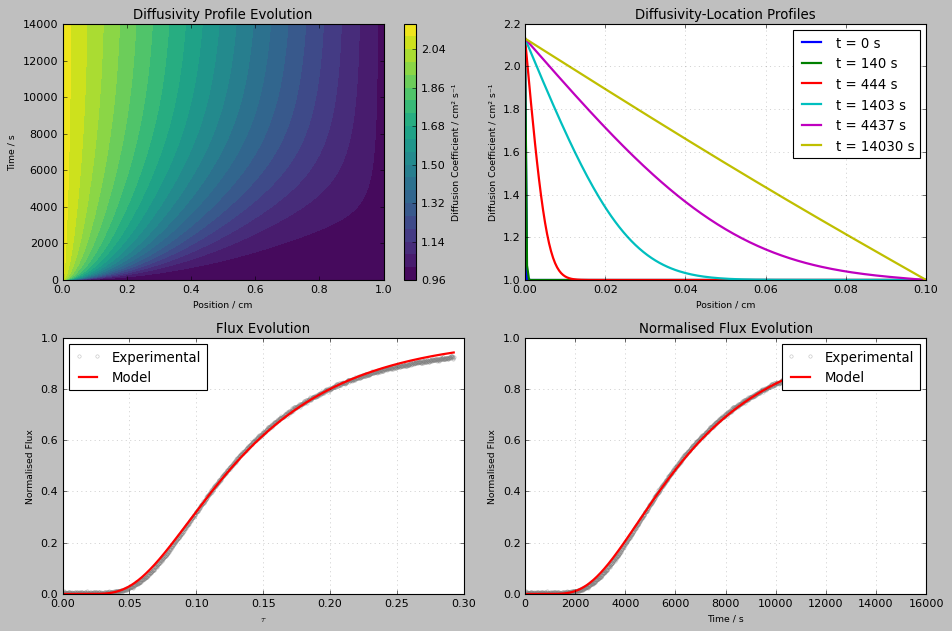

In [ ]:
# Example usage:
# fit_results = fit_data_LBFGSB_multistarts_adaptive(processed_exp_data, 
#                                                      initial_guess=(2.0, 1.0e-7), 
#                                                      bounds=((1.001, 10), (1e-8, 1e-6)), 
#                                                      n_starts=1)
fit_results = fit_data_LBFGSB_multistarts_adaptive(
    processed_exp_data,
    initial_guess=(2.0, 1.0e-7), 
    bounds=((1.001, 10), (1e-8, 1e-6)), 
    n_starts=1,
    minimisation_options={
        'ftol': 1e-5,
        'gtol': 1e-5,
        'eps': 1e-8,
        'maxiter': 100,
        'maxfun': 200,
        'maxcor': 50
        })

print(fit_results)
processed_exp_data['tau'] = fit_results['DT_0'] * processed_exp_data['time'] / model.params.transport.thickness**2
model, Dprime_df, flux_df, figures = manual_workflow(
    pressure=model.params.base.pressure,
    temperature=model.params.base.temperature,
    thickness=model.params.transport.thickness,
    diameter=model.params.transport.diameter,
    flowrate=model.params.transport.flowrate,
    D1_prime=fit_results['D1_prime'],
    DT_0=fit_results['DT_0'],
    experimental_data=processed_exp_data,
    simulation_params={
        'T': processed_exp_data['time'].max(),
        'X': 1.0,
        'dx': 0.005,
        },
    output_settings={
            'output_dir': 'outputs/fitting',
            'display_plots': True,
            'save_plots': False,
            'save_data': False,
            'plot_format': 'png',
            'data_format': 'csv'
    }
)

Stress test a range of initial values using a range of `minimisation_options`.

In [14]:
import time

# D1_primes = [2.0, 5.0, 10.0, 20.0]
# DT_0s = [1e-7, 1e-6, 1e-5, 1e-4]
D1_primes = [2.0, ]
DT_0s = [1e-7, 1e-6]

results = []
for D1_prime in D1_primes:
    for DT_0 in DT_0s:
        initial_guess = (D1_prime, DT_0)
        try:
            start_time = time.time()
            fit_result = fit_data_LBFGSB_multistarts_adaptive(
                processed_exp_data,
                initial_guess=initial_guess,
                bounds=((1.001, 10), (1e-8, 1e-6)),
                n_starts=1,
                minimisation_options={
                'ftol': 1e-6,
                'gtol': 1e-6,
                'eps': 1e-8,
                'maxiter': 100,
                'maxfun': 200,
                'maxcor': 50
                }
            )
            end_time = time.time()
            fit_time = end_time - start_time
            results.append({
                'D1_prime_initial': D1_prime,
                'DT_0_initial': DT_0,
                'D1_prime_fitted': fit_result['D1_prime'],
                'DT_0_fitted': fit_result['DT_0'],
                'rmse': fit_result['rmse'],
                'optimisation_result': fit_result['optimisation_result'],
                'optimisation_history': fit_result['optimisation_history'],
                'n_successful': fit_result['n_successful'],
                'fit_time': fit_time
            })
            print(f"Initial guess D1_prime={D1_prime}, DT_0={DT_0}: RMSE = {fit_result['rmse']}, Fit time = {fit_time:.2f} seconds")
        except Exception as e:
            print(f"Error with initial guess D1_prime={D1_prime}, DT_0={DT_0}: {e}")

# Print all results
print("\nAll Results:")
for result in results:
    print(f"Initial D1_prime: {result['D1_prime_initial']}, Initial DT_0: {result['DT_0_initial']}, Fitted D1_prime: {result['D1_prime_fitted']}, Fitted DT_0: {result['DT_0_fitted']}, RMSE: {result['rmse']}, n_successful: {result['n_successful']}, Fit time: {result['fit_time']:.2f} seconds")

Fitting (multi-start): 0iter [00:00, ?iter/s]

Adaptive PDE Solve (D1'=2.0, DTO=1e-07): 14030.87547263367it [00:00, 34955.65it/s]                  
Adaptive PDE Solve (D1'=2.00000001, DTO=1e-07): 14030.87547263367it [00:00, 51371.55it/s]           
Adaptive PDE Solve (D1'=2.0, DTO=1.0000000099999999e-07): 14030.87547263367it [00:00, 51141.73it/s] 
Adaptive PDE Solve (D1'=2.056216887042978, DTO=1.4795653792135516e-07): 14035.348355856482it [00:00, 30901.04it/s]
Adaptive PDE Solve (D1'=2.0562168970429777, DTO=1.4795653792135516e-07): 14035.348355856482it [00:00, 31116.12it/s]
Adaptive PDE Solve (D1'=2.056216887042978, DTO=1.4795653892135516e-07): 14035.348355856482it [00:00, 31775.17it/s]
Adaptive PDE Solve (D1'=2.6308090666957433, DTO=2.920061023821256e-07): 14030.596491460885it [00:01, 13244.99it/s]
Adaptive PDE Solve (D1'=2.6308090766957433, DTO=2.920061023821256e-07): 14030.596491460885it [00:01, 13717.72it/s]
Adaptive PDE Solve (D1'=2.6308090666957433, DTO=2.920061033821256e-07): 14030.596491460885it [00:00, 14042.07it/s]
Adapti

Initial guess D1_prime=2.0, DT_0=1e-07: RMSE = 0.009231310762173397, Fit time = 28.04 seconds


Fitting (multi-start): 0iter [00:00, ?iter/s]

Adaptive PDE Solve (D1'=2.0, DTO=1e-06): 14032.80798501872it [00:01, 10156.42it/s]                  
Adaptive PDE Solve (D1'=2.00000001, DTO=1e-06): 14032.80798501872it [00:01, 9930.03it/s]            
Adaptive PDE Solve (D1'=2.0, DTO=9.9999999e-07): 14032.80798501872it [00:01, 10778.03it/s]          
Adaptive PDE Solve (D1'=1.9748069633010892, DTO=8.628159754386693e-07): 14038.597920837945it [00:01, 11436.78it/s]
Adaptive PDE Solve (D1'=1.9748069733010891, DTO=8.628159754386693e-07): 14038.597920837945it [00:01, 11420.39it/s]
Adaptive PDE Solve (D1'=1.9748069633010892, DTO=8.628159854386694e-07): 14038.597920837945it [00:01, 11521.93it/s]
Adaptive PDE Solve (D1'=1.9450836504204325, DTO=6.752089409190712e-07): 14032.835992576056it [00:01, 12123.13it/s]
Adaptive PDE Solve (D1'=1.9450836604204325, DTO=6.752089409190712e-07): 14032.835992576056it [00:01, 11457.42it/s]
Adaptive PDE Solve (D1'=1.9450836504204325, DTO=6.752089509190713e-07): 14032.835992576056it [00:01, 12204.59it/s]
Adaptiv

Initial guess D1_prime=2.0, DT_0=1e-06: RMSE = 0.010250000191065482, Fit time = 34.53 seconds

All Results:
Initial D1_prime: 2.0, Initial DT_0: 1e-07, Fitted D1_prime: 2.130147083546674, Fitted DT_0: 2.0831730708757286e-07, RMSE: 0.009231310762173397, n_successful: 1, Fit time: 28.04 seconds
Initial D1_prime: 2.0, Initial DT_0: 1e-06, Fitted D1_prime: 1.8725475088414134, Fitted DT_0: 2.165105916324318e-07, RMSE: 0.010250000191065482, n_successful: 1, Fit time: 34.53 seconds


In [17]:
import time

# D1_primes = [2.0, 5.0, 10.0, 20.0]
# DT_0s = [1e-7, 1e-6, 1e-5, 1e-4]
D1_primes = [2.0, ]
DT_0s = [1e-7, 1e-6]

results = []
for D1_prime in D1_primes:
    for DT_0 in DT_0s:
        initial_guess = (D1_prime, DT_0)
        try:
            start_time = time.time()
            fit_result = fit_data_LBFGSB_multistarts_adaptive(
                processed_exp_data,
                initial_guess=initial_guess,
                bounds=((1.001, 10), (1e-8, 1e-6)),
                n_starts=1,
                minimisation_options={
                'ftol': 1e-7,
                'gtol': 1e-6,
                'eps': 1e-8,
                'maxiter': 100,
                'maxfun': 200,
                'maxcor': 50
                }
            )
            end_time = time.time()
            fit_time = end_time - start_time
            results.append({
                'D1_prime_initial': D1_prime,
                'DT_0_initial': DT_0,
                'D1_prime_fitted': fit_result['D1_prime'],
                'DT_0_fitted': fit_result['DT_0'],
                'rmse': fit_result['rmse'],
                'optimisation_result': fit_result['optimisation_result'],
                'optimisation_history': fit_result['optimisation_history'],
                'n_successful': fit_result['n_successful'],
                'fit_time': fit_time
            })
            print(f"Initial guess D1_prime={D1_prime}, DT_0={DT_0}: RMSE = {fit_result['rmse']}, Fit time = {fit_time:.2f} seconds")
        except Exception as e:
            print(f"Error with initial guess D1_prime={D1_prime}, DT_0={DT_0}: {e}")

# Print all results
print("\nAll Results:")
for result in results:
    print(f"Initial D1_prime: {result['D1_prime_initial']}, Initial DT_0: {result['DT_0_initial']}, Fitted D1_prime: {result['D1_prime_fitted']}, Fitted DT_0: {result['DT_0_fitted']}, RMSE: {result['rmse']}, n_successful: {result['n_successful']}, Fit time: {result['fit_time']:.2f} seconds")

Fitting (multi-start): 0iter [00:00, ?iter/s]







Adaptive PDE Solve (D1'=2.0, DTO=1e-07): 14030.87547263367it [00:00, 50306.29it/s]                  






Adaptive PDE Solve (D1'=2.00000001, DTO=1e-07): 14030.87547263367it [00:00, 52705.41it/s]           






Adaptive PDE Solve (D1'=2.0, DTO=1.0000000099999999e-07): 14030.87547263367it [00:00, 54138.81it/s] 










Adaptive PDE Solve (D1'=2.056216887042978, DTO=1.4795653792135516e-07): 14035.348355856482it [00:00, 32603.16it/s]










Adaptive PDE Solve (D1'=2.0562168970429777, DTO=1.4795653792135516e-07): 14035.348355856482it [00:00, 31850.19it/s]








Adaptive PDE Solve (D1'=2.056216887042978, DTO=1.4795653892135516e-07): 14035.348355856482it [00:00, 32739.65it/s]






















Adaptive PDE Solve (D1'=2.6308090666957433, DTO=2.920061023821256e-07): 14030.596491460885it [00:01, 12757.56it/s]




















Adaptive PDE Solve (D1'=2.6308090766957433, DTO=2.920061023821256e-07): 14030.596491460885it [00:01, 13915.79it/s]




















Adaptive PDE 

Initial guess D1_prime=2.0, DT_0=1e-07: RMSE = 0.009231310738990006, Fit time = 61.59 seconds


Fitting (multi-start): 0iter [00:00, ?iter/s]



























Adaptive PDE Solve (D1'=2.0, DTO=1e-06): 14032.80798501872it [00:01, 10386.88it/s]                  


























Adaptive PDE Solve (D1'=2.00000001, DTO=1e-06): 14032.80798501872it [00:01, 11212.23it/s]           


























Adaptive PDE Solve (D1'=2.0, DTO=9.9999999e-07): 14032.80798501872it [00:01, 11263.33it/s]          
























Adaptive PDE Solve (D1'=1.9748069633010892, DTO=8.628159754386693e-07): 14038.597920837945it [00:01, 11639.73it/s]


























Adaptive PDE Solve (D1'=1.9748069733010891, DTO=8.628159754386693e-07): 14038.597920837945it [00:01, 11536.38it/s]
























Adaptive PDE Solve (D1'=1.9748069633010892, DTO=8.628159854386694e-07): 14038.597920837945it [00:01, 11682.72it/s]


























Adaptive PDE Solve (D1'=1.9450836504204325, DTO=6.752089409190712e-07): 14032.835992576056it [00:01, 11243.95it/s]
























Adaptive PDE Solve (D1'=1.945083660

Initial guess D1_prime=2.0, DT_0=1e-06: RMSE = 0.009231323028348823, Fit time = 58.74 seconds

All Results:
Initial D1_prime: 2.0, Initial DT_0: 1e-07, Fitted D1_prime: 2.130150166399067, Fitted DT_0: 2.0831727005297474e-07, RMSE: 0.009231310738990006, n_successful: 1, Fit time: 61.59 seconds
Initial D1_prime: 2.0, Initial DT_0: 1e-06, Fitted D1_prime: 2.1302444810752785, Fitted DT_0: 2.0831500178451538e-07, RMSE: 0.009231323028348823, n_successful: 1, Fit time: 58.74 seconds


In [18]:
import time

# D1_primes = [2.0, 5.0, 10.0, 20.0]
# DT_0s = [1e-7, 1e-6, 1e-5, 1e-4]
D1_primes = [2.0, ]
DT_0s = [1e-7, 1e-6]

results = []
for D1_prime in D1_primes:
    for DT_0 in DT_0s:
        initial_guess = (D1_prime, DT_0)
        try:
            start_time = time.time()
            fit_result = fit_data_LBFGSB_multistarts_adaptive(
                processed_exp_data,
                initial_guess=initial_guess,
                bounds=((1.001, 10), (1e-8, 1e-6)),
                n_starts=1,
                minimisation_options={
                'ftol': 1e-6,
                'gtol': 1e-7,
                'eps': 1e-8,
                'maxiter': 100,
                'maxfun': 200,
                'maxcor': 50
                }
            )
            end_time = time.time()
            fit_time = end_time - start_time
            results.append({
                'D1_prime_initial': D1_prime,
                'DT_0_initial': DT_0,
                'D1_prime_fitted': fit_result['D1_prime'],
                'DT_0_fitted': fit_result['DT_0'],
                'rmse': fit_result['rmse'],
                'optimisation_result': fit_result['optimisation_result'],
                'optimisation_history': fit_result['optimisation_history'],
                'n_successful': fit_result['n_successful'],
                'fit_time': fit_time
            })
            print(f"Initial guess D1_prime={D1_prime}, DT_0={DT_0}: RMSE = {fit_result['rmse']}, Fit time = {fit_time:.2f} seconds")
        except Exception as e:
            print(f"Error with initial guess D1_prime={D1_prime}, DT_0={DT_0}: {e}")

# Print all results
print("\nAll Results:")
for result in results:
    print(f"Initial D1_prime: {result['D1_prime_initial']}, Initial DT_0: {result['DT_0_initial']}, Fitted D1_prime: {result['D1_prime_fitted']}, Fitted DT_0: {result['DT_0_fitted']}, RMSE: {result['rmse']}, n_successful: {result['n_successful']}, Fit time: {result['fit_time']:.2f} seconds")

Fitting (multi-start): 0iter [00:00, ?iter/s]







Adaptive PDE Solve (D1'=2.0, DTO=1e-07): 14030.87547263367it [00:00, 51429.33it/s]                  






Adaptive PDE Solve (D1'=2.00000001, DTO=1e-07): 14030.87547263367it [00:00, 52106.68it/s]           






Adaptive PDE Solve (D1'=2.0, DTO=1.0000000099999999e-07): 14030.87547263367it [00:00, 52797.05it/s] 










Adaptive PDE Solve (D1'=2.056216887042978, DTO=1.4795653792135516e-07): 14035.348355856482it [00:00, 32476.80it/s]










Adaptive PDE Solve (D1'=2.0562168970429777, DTO=1.4795653792135516e-07): 14035.348355856482it [00:00, 31986.77it/s]










Adaptive PDE Solve (D1'=2.056216887042978, DTO=1.4795653892135516e-07): 14035.348355856482it [00:00, 32852.26it/s]






















Adaptive PDE Solve (D1'=2.6308090666957433, DTO=2.920061023821256e-07): 14030.596491460885it [00:01, 12565.91it/s]




















Adaptive PDE Solve (D1'=2.6308090766957433, DTO=2.920061023821256e-07): 14030.596491460885it [00:00, 14230.42it/s]




















Adaptive PD

Initial guess D1_prime=2.0, DT_0=1e-07: RMSE = 0.009231310762173397, Fit time = 27.15 seconds


Fitting (multi-start): 0iter [00:00, ?iter/s]



























Adaptive PDE Solve (D1'=2.0, DTO=1e-06): 14032.80798501872it [00:01, 10487.80it/s]                  


























Adaptive PDE Solve (D1'=2.00000001, DTO=1e-06): 14032.80798501872it [00:01, 10721.71it/s]           


























Adaptive PDE Solve (D1'=2.0, DTO=9.9999999e-07): 14032.80798501872it [00:01, 10828.42it/s]          


























Adaptive PDE Solve (D1'=1.9748069633010892, DTO=8.628159754386693e-07): 14038.597920837945it [00:01, 10995.42it/s]


























Adaptive PDE Solve (D1'=1.9748069733010891, DTO=8.628159754386693e-07): 14038.597920837945it [00:01, 10584.19it/s]
























Adaptive PDE Solve (D1'=1.9748069633010892, DTO=8.628159854386694e-07): 14038.597920837945it [00:01, 11397.58it/s]
























Adaptive PDE Solve (D1'=1.9450836504204325, DTO=6.752089409190712e-07): 14032.835992576056it [00:01, 12110.48it/s]
























Adaptive PDE Solve (D1'=1.945083660

Initial guess D1_prime=2.0, DT_0=1e-06: RMSE = 0.010250000191065482, Fit time = 35.02 seconds

All Results:
Initial D1_prime: 2.0, Initial DT_0: 1e-07, Fitted D1_prime: 2.130147083546674, Fitted DT_0: 2.0831730708757286e-07, RMSE: 0.009231310762173397, n_successful: 1, Fit time: 27.15 seconds
Initial D1_prime: 2.0, Initial DT_0: 1e-06, Fitted D1_prime: 1.8725475088414134, Fitted DT_0: 2.165105916324318e-07, RMSE: 0.010250000191065482, n_successful: 1, Fit time: 35.02 seconds


In [19]:
import time

# D1_primes = [2.0, 5.0, 10.0, 20.0]
# DT_0s = [1e-7, 1e-6, 1e-5, 1e-4]
D1_primes = [2.0, ]
DT_0s = [1e-7, 1e-6]

results = []
for D1_prime in D1_primes:
    for DT_0 in DT_0s:
        initial_guess = (D1_prime, DT_0)
        try:
            start_time = time.time()
            fit_result = fit_data_LBFGSB_multistarts_adaptive(
                processed_exp_data,
                initial_guess=initial_guess,
                bounds=((1.001, 10), (1e-8, 1e-6)),
                n_starts=1,
                minimisation_options={
                'ftol': 1e-7,
                'gtol': 1e-7,
                'eps': 1e-8,
                'maxiter': 100,
                'maxfun': 200,
                'maxcor': 50
                }
            )
            end_time = time.time()
            fit_time = end_time - start_time
            results.append({
                'D1_prime_initial': D1_prime,
                'DT_0_initial': DT_0,
                'D1_prime_fitted': fit_result['D1_prime'],
                'DT_0_fitted': fit_result['DT_0'],
                'rmse': fit_result['rmse'],
                'optimisation_result': fit_result['optimisation_result'],
                'optimisation_history': fit_result['optimisation_history'],
                'n_successful': fit_result['n_successful'],
                'fit_time': fit_time
            })
            print(f"Initial guess D1_prime={D1_prime}, DT_0={DT_0}: RMSE = {fit_result['rmse']}, Fit time = {fit_time:.2f} seconds")
        except Exception as e:
            print(f"Error with initial guess D1_prime={D1_prime}, DT_0={DT_0}: {e}")

# Print all results
print("\nAll Results:")
for result in results:
    print(f"Initial D1_prime: {result['D1_prime_initial']}, Initial DT_0: {result['DT_0_initial']}, Fitted D1_prime: {result['D1_prime_fitted']}, Fitted DT_0: {result['DT_0_fitted']}, RMSE: {result['rmse']}, n_successful: {result['n_successful']}, Fit time: {result['fit_time']:.2f} seconds")

Fitting (multi-start): 0iter [00:00, ?iter/s]







Adaptive PDE Solve (D1'=2.0, DTO=1e-07): 14030.87547263367it [00:00, 52756.16it/s]                  






Adaptive PDE Solve (D1'=2.00000001, DTO=1e-07): 14030.87547263367it [00:00, 53766.07it/s]           






Adaptive PDE Solve (D1'=2.0, DTO=1.0000000099999999e-07): 14030.87547263367it [00:00, 51978.60it/s] 










Adaptive PDE Solve (D1'=2.056216887042978, DTO=1.4795653792135516e-07): 14035.348355856482it [00:00, 31668.38it/s]












Adaptive PDE Solve (D1'=2.0562168970429777, DTO=1.4795653792135516e-07): 14035.348355856482it [00:00, 26594.80it/s]










Adaptive PDE Solve (D1'=2.056216887042978, DTO=1.4795653892135516e-07): 14035.348355856482it [00:00, 32177.91it/s]




















Adaptive PDE Solve (D1'=2.6308090666957433, DTO=2.920061023821256e-07): 14030.596491460885it [00:00, 14169.62it/s]






















Adaptive PDE Solve (D1'=2.6308090766957433, DTO=2.920061023821256e-07): 14030.596491460885it [00:01, 13544.92it/s]




















Adaptive 

Initial guess D1_prime=2.0, DT_0=1e-07: RMSE = 0.009231310738990006, Fit time = 62.70 seconds


Fitting (multi-start): 0iter [00:00, ?iter/s]



























Adaptive PDE Solve (D1'=2.0, DTO=1e-06): 14032.80798501872it [00:01, 10750.23it/s]                  




























Adaptive PDE Solve (D1'=2.00000001, DTO=1e-06): 14032.80798501872it [00:01, 10097.63it/s]           


























Adaptive PDE Solve (D1'=2.0, DTO=9.9999999e-07): 14032.80798501872it [00:01, 11000.11it/s]          


























Adaptive PDE Solve (D1'=1.9748069633010892, DTO=8.628159754386693e-07): 14038.597920837945it [00:01, 11258.52it/s]


























Adaptive PDE Solve (D1'=1.9748069733010891, DTO=8.628159754386693e-07): 14038.597920837945it [00:01, 11154.37it/s]
























Adaptive PDE Solve (D1'=1.9748069633010892, DTO=8.628159854386694e-07): 14038.597920837945it [00:01, 11335.75it/s]
























Adaptive PDE Solve (D1'=1.9450836504204325, DTO=6.752089409190712e-07): 14032.835992576056it [00:01, 12094.41it/s]
























Adaptive PDE Solve (D1'=1.9450836

Initial guess D1_prime=2.0, DT_0=1e-06: RMSE = 0.009231323028348823, Fit time = 58.67 seconds

All Results:
Initial D1_prime: 2.0, Initial DT_0: 1e-07, Fitted D1_prime: 2.130150166399067, Fitted DT_0: 2.0831727005297474e-07, RMSE: 0.009231310738990006, n_successful: 1, Fit time: 62.70 seconds
Initial D1_prime: 2.0, Initial DT_0: 1e-06, Fitted D1_prime: 2.1302444810752785, Fitted DT_0: 2.0831500178451538e-07, RMSE: 0.009231323028348823, n_successful: 1, Fit time: 58.67 seconds


In [6]:
import time

# D1_primes = [2.0, 5.0, 10.0, 20.0]
# DT_0s = [1e-7, 1e-6, 1e-5, 1e-4]
D1_primes = [2.0, ]
DT_0s = [1e-7, 1e-6]

results = []
for D1_prime in D1_primes:
    for DT_0 in DT_0s:
        initial_guess = (D1_prime, DT_0)
        try:
            start_time = time.time()
            fit_result = fit_data_LBFGSB_multistarts_adaptive(
                processed_exp_data,
                initial_guess=initial_guess,
                bounds=((1.001, 10), (1e-8, 1e-6)),
                n_starts=1,
                minimisation_options={
                    'ftol': 1e-8,
                    'gtol': 1e-8,
                    'eps': 1e-8,
                    'maxiter': 100,
                    'maxfun': 200,
                    'maxcor': 50
                }
            )
            end_time = time.time()
            fit_time = end_time - start_time
            results.append({
                'D1_prime_initial': D1_prime,
                'DT_0_initial': DT_0,
                'D1_prime_fitted': fit_result['D1_prime'],
                'DT_0_fitted': fit_result['DT_0'],
                'rmse': fit_result['rmse'],
                'optimisation_result': fit_result['optimisation_result'],
                'optimisation_history': fit_result['optimisation_history'],
                'n_successful': fit_result['n_successful'],
                'fit_time': fit_time
            })
            print(f"Initial guess D1_prime={D1_prime}, DT_0={DT_0}: RMSE = {fit_result['rmse']}, Fit time = {fit_time:.2f} seconds")
        except Exception as e:
            print(f"Error with initial guess D1_prime={D1_prime}, DT_0={DT_0}: {e}")

# Print all results
print("\nAll Results:")
for result in results:
    print(f"Initial D1_prime: {result['D1_prime_initial']}, Initial DT_0: {result['DT_0_initial']}, Fitted D1_prime: {result['D1_prime_fitted']}, Fitted DT_0: {result['DT_0_fitted']}, RMSE: {result['rmse']}, n_successful: {result['n_successful']}, Fit time: {result['fit_time']:.2f} seconds")

Fitting (multi-start): 0iter [00:00, ?iter/s]

Initial guess D1_prime=2.0, DT_0=1e-07: RMSE = 0.009231310738990006, Fit time = 63.63 seconds


Fitting (multi-start): 0iter [00:00, ?iter/s]

Initial guess D1_prime=2.0, DT_0=1e-06: RMSE = 0.009231320686381857, Fit time = 65.48 seconds

All Results:
Initial D1_prime: 2.0, Initial DT_0: 1e-07, Fitted D1_prime: 2.130150166399067, Fitted DT_0: 2.0831727005297474e-07, RMSE: 0.009231310738990006, n_successful: 1, Fit time: 63.63 seconds
Initial D1_prime: 2.0, Initial DT_0: 1e-06, Fitted D1_prime: 2.130184986093536, Fitted DT_0: 2.0831679705083048e-07, RMSE: 0.009231320686381857, n_successful: 1, Fit time: 65.48 seconds


In [ ]:
import time

D1_primes = [2.0, 5.0, 10.0, 20.0]
DT_0s = [1e-7, 1e-6, 1e-5, 1e-4]
# D1_primes = [2.0, ]
# DT_0s = [1e-7, 1e-6]

results = []
for D1_prime in D1_primes:
    for DT_0 in DT_0s:
        initial_guess = (D1_prime, DT_0)
        try:
            start_time = time.time()
            fit_result = fit_data_LBFGSB_multistarts_adaptive(
                processed_exp_data,
                initial_guess=initial_guess,
                bounds=((1.001, 10), (1e-8, 1e-6)),
                n_starts=1,
                minimisation_options={
                    'ftol': 1e-8,
                    'gtol': 1e-8,
                    'eps': 1e-8,
                    'maxiter': 100,
                    'maxfun': 200,
                    'maxcor': 50
                }
            )
            end_time = time.time()
            fit_time = end_time - start_time
            results.append({
                'D1_prime_initial': D1_prime,
                'DT_0_initial': DT_0,
                'D1_prime_fitted': fit_result['D1_prime'],
                'DT_0_fitted': fit_result['DT_0'],
                'rmse': fit_result['rmse'],
                'optimisation_result': fit_result['optimisation_result'],
                'optimisation_history': fit_result['optimisation_history'],
                'n_successful': fit_result['n_successful'],
                'fit_time': fit_time
            })
            print(f"Initial guess D1_prime={D1_prime}, DT_0={DT_0}: RMSE = {fit_result['rmse']}, Fit time = {fit_time:.2f} seconds")
        except Exception as e:
            print(f"Error with initial guess D1_prime={D1_prime}, DT_0={DT_0}: {e}")

# Print all results
print("\nAll Results:")
for result in results:
    print(f"Initial D1_prime: {result['D1_prime_initial']}, Initial DT_0: {result['DT_0_initial']}, Fitted D1_prime: {result['D1_prime_fitted']}, Fitted DT_0: {result['DT_0_fitted']}, RMSE: {result['rmse']}, n_successful: {result['n_successful']}, Fit time: {result['fit_time']:.2f} seconds")

Fitting (multi-start): 0iter [00:00, ?iter/s]

Initial guess D1_prime=2.0, DT_0=1e-07: RMSE = 0.009231310738990006, Fit time = 57.81 seconds


Fitting (multi-start): 0iter [00:00, ?iter/s]

Initial guess D1_prime=2.0, DT_0=1e-06: RMSE = 0.009231320686381857, Fit time = 56.88 seconds


Fitting (multi-start): 0iter [00:00, ?iter/s]

Initial guess D1_prime=2.0, DT_0=1e-05: RMSE = 0.009580789046509455, Fit time = 31.96 seconds


Fitting (multi-start): 0iter [00:00, ?iter/s]

Initial guess D1_prime=2.0, DT_0=0.0001: RMSE = 0.009580795643573038, Fit time = 30.01 seconds


Fitting (multi-start): 0iter [00:00, ?iter/s]

Initial guess D1_prime=5.0, DT_0=1e-07: RMSE = 0.009231320686667373, Fit time = 45.90 seconds


Fitting (multi-start): 0iter [00:00, ?iter/s]

Initial guess D1_prime=5.0, DT_0=1e-06: RMSE = 0.009231320686553137, Fit time = 114.92 seconds


Fitting (multi-start): 0iter [00:00, ?iter/s]

Initial guess D1_prime=5.0, DT_0=1e-05: RMSE = 0.00923132192509372, Fit time = 114.92 seconds


Fitting (multi-start): 0iter [00:00, ?iter/s]

Initial guess D1_prime=5.0, DT_0=0.0001: RMSE = 0.034427748674704474, Fit time = 55.16 seconds


Fitting (multi-start): 0iter [00:00, ?iter/s]

Initial guess D1_prime=10.0, DT_0=1e-07: RMSE = 0.009231320687357047, Fit time = 68.21 seconds


Fitting (multi-start): 0iter [00:00, ?iter/s]

Initial guess D1_prime=10.0, DT_0=1e-06: RMSE = 0.009231320686420469, Fit time = 117.50 seconds


Fitting (multi-start): 0iter [00:00, ?iter/s]

Initial guess D1_prime=10.0, DT_0=1e-05: RMSE = 0.009231334359800024, Fit time = 145.59 seconds


Fitting (multi-start): 0iter [00:00, ?iter/s]

Initial guess D1_prime=10.0, DT_0=0.0001: RMSE = 0.00923132069609175, Fit time = 173.77 seconds


Fitting (multi-start): 0iter [00:00, ?iter/s]

Initial guess D1_prime=20.0, DT_0=1e-07: RMSE = 0.009231320687357047, Fit time = 67.61 seconds


Fitting (multi-start): 0iter [00:00, ?iter/s]

Initial guess D1_prime=20.0, DT_0=1e-06: RMSE = 0.009231320686420469, Fit time = 117.37 seconds


Fitting (multi-start): 0iter [00:00, ?iter/s]

Initial guess D1_prime=20.0, DT_0=1e-05: RMSE = 0.009231334359800024, Fit time = 145.99 seconds


Fitting (multi-start): 0iter [00:00, ?iter/s]

Initial guess D1_prime=20.0, DT_0=0.0001: RMSE = 0.00923132069609175, Fit time = 174.25 seconds

All Results:
Initial D1_prime: 2.0, Initial DT_0: 1e-07, Fitted D1_prime: 2.130150166399067, Fitted DT_0: 2.0831727005297474e-07, RMSE: 0.009231310738990006, n_successful: 1, Fit time: 57.81 seconds
Initial D1_prime: 2.0, Initial DT_0: 1e-06, Fitted D1_prime: 2.130184986093536, Fitted DT_0: 2.0831679705083048e-07, RMSE: 0.009231320686381857, n_successful: 1, Fit time: 56.88 seconds
Initial D1_prime: 2.0, Initial DT_0: 1e-05, Fitted D1_prime: 1.9788080257394645, Fitted DT_0: 2.1301912520061963e-07, RMSE: 0.009580789046509455, n_successful: 1, Fit time: 31.96 seconds
Initial D1_prime: 2.0, Initial DT_0: 0.0001, Fitted D1_prime: 1.9788070892647267, Fitted DT_0: 2.13019899689623e-07, RMSE: 0.009580795643573038, n_successful: 1, Fit time: 30.01 seconds
Initial D1_prime: 5.0, Initial DT_0: 1e-07, Fitted D1_prime: 2.130179420065687, Fitted DT_0: 2.0831695103729325e-07, RMSE: 0.009231320686667373, 

## Nelder-Mead

In [10]:
def fit_data_Nelder_Mead(data, initial_guess=5.0):
    # Store last objective value for callback
    last_rmse = [float('inf')]
    
    def objective(params):
        D1_prime = params
        _, flux_df = model._solve_pde(
            L=model.params.transport.thickness,
            D1_prime=D1_prime,
            DT_0=model.params.transport.DT_0,
            T=data['time'].max(),
            X=1.0,
            dx=0.005,
        )
        
        # Interpolate model norm flux to data time points
        model_norm_flux = np.interp(data['tau'], flux_df['tau'], flux_df['normalised_flux'])
        
        # Calculate RMSE
        rmse = np.sqrt(np.mean((data['normalised_flux'] - model_norm_flux)**2))
        last_rmse[0] = rmse
        
        return rmse
    
    # Initial guess from current parameters (optimizing D1_prime only; DT_0 remains fixed)
    x0 = [initial_guess]
    
    # Optimize
    result = minimize(
        lambda x: objective(x[0]),
        x0=x0,
        method='Nelder-Mead',
        callback=None,
    )
    
    # Print results
    print(f"Optimization result: {result}")   
    
    return result.x[0], last_rmse[0]

Adaptive PDE Solve (D1'=5.0, DTO=2.38e-07): 44162.868114456105it [00:01, 26112.38it/s]              
Adaptive PDE Solve (D1'=5.25, DTO=2.38e-07): 44169.52141970966it [00:01, 27363.13it/s]              
Adaptive PDE Solve (D1'=4.75, DTO=2.38e-07): 44168.5685931025it [00:01, 28620.62it/s]               
Adaptive PDE Solve (D1'=4.5, DTO=2.38e-07):  45%|▍| 19680.29146525265/44160.0 [00:01<00:00, 25043.12c:\Users\sieun\anaconda3\envs\permeationenv\Lib\site-packages\tqdm\std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Adaptive PDE Solve (D1'=4.5, DTO=2.38e-07): 100%|█| 44160.29146525265/44160.0 [00:01<00:00, 29629.41
Adaptive PDE Solve (D1'=4.0, DTO=2.38e-07): 44168.50037209686it [00:01, 31444.48it/s]               
Adaptive PDE Solve (D1'=3.5, DTO=2.38e-07): 44168.13597441362it [00:01, 34042.79it/s]               
Adaptive PDE Solve (D1'=2.5, DTO=2.38e-07): 44163.56795598284it [00:01, 41615.73it/s]               
Adaptive PDE Solve (D1'=1.5, DTO=2.38e-07): 4416

Optimization result:        message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.013637090023115545
             x: [ 1.125e+00]
           nit: 22
          nfev: 47
 final_simplex: (array([[ 1.125e+00],
                       [ 1.125e+00]]), array([ 1.364e-02,  1.364e-02]))


Adaptive PDE Solve (D1'=1.124755859375, DTO=2.38e-07): 44163.186486462466it [00:00, 93449.60it/s]   


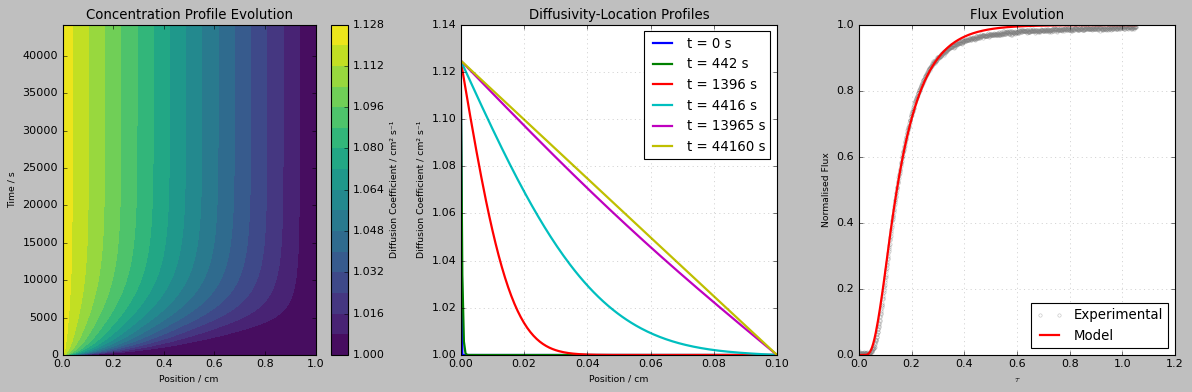

In [11]:
fit_results = fit_data_Nelder_Mead(processed_exp_data, initial_guess=5.0)
model, Dprime_df, flux_df, figures = manual_workflow(
    pressure=model.params.base.pressure,
    temperature=model.params.base.temperature,
    thickness=model.params.transport.thickness,
    diameter=model.params.transport.diameter,
    flowrate=model.params.transport.flowrate,
    D1_prime=fit_results[0],
    DT_0=model.params.transport.DT_0,
    experimental_data=processed_exp_data,
    simulation_params={
        'T': processed_exp_data['time'].max(),
        'X': 1.0,
        'dx': 0.005,
        },
    output_settings={
            'output_dir': 'outputs/fitting',
            'display_plots': True,
            'save_plots': False,
            'save_data': False,
            'plot_format': 'png',
            'data_format': 'csv'
    }
)


## BFGS

In [12]:
def fit_data_BFGS(data, initial_guess=5.0):
    # Store last objective value for callback
    last_rmse = [float('inf')]
    
    def objective(params):
        D1_prime = params
        _, flux_df = model._solve_pde(
            L=model.params.transport.thickness,
            D1_prime=D1_prime,
            DT_0=model.params.transport.DT_0,
            T=data['time'].max(),
            X=1.0,
            dx=0.005,
        )
        
        # Interpolate model norm flux to data time points
        model_norm_flux = np.interp(data['tau'], flux_df['tau'], flux_df['normalised_flux'])
        
        # Calculate RMSE
        rmse = np.sqrt(np.mean((data['normalised_flux'] - model_norm_flux)**2))
        last_rmse[0] = rmse
        
        return rmse
    
    # Initial guess from current parameters (optimizing D1_prime only; DT_0 remains fixed)
    x0 = [initial_guess]
    
    # Optimize
    result = minimize(
        lambda x: objective(x[0]),
        x0=x0,
        method='Nelder-Mead',
        callback=None,
    )
    
    # Print results
    print(f"Optimization result: {result}")   
    
    return result.x[0], last_rmse[0]

Adaptive PDE Solve (D1'=5.0, DTO=2.38e-07): 44162.868114456105it [00:01, 27806.98it/s]              
Adaptive PDE Solve (D1'=5.25, DTO=2.38e-07): 44169.52141970966it [00:01, 25754.86it/s]              
Adaptive PDE Solve (D1'=4.75, DTO=2.38e-07): 44168.5685931025it [00:01, 28691.57it/s]               
Adaptive PDE Solve (D1'=4.5, DTO=2.38e-07):  37%|▎| 16523.61202475265/44160.0 [00:01<00:01, 18432.30c:\Users\sieun\anaconda3\envs\permeationenv\Lib\site-packages\tqdm\std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Adaptive PDE Solve (D1'=4.5, DTO=2.38e-07): 100%|█| 44160.29146525265/44160.0 [00:01<00:00, 29645.96
Adaptive PDE Solve (D1'=4.0, DTO=2.38e-07): 44168.50037209686it [00:01, 31344.69it/s]               
Adaptive PDE Solve (D1'=3.5, DTO=2.38e-07): 44168.13597441362it [00:01, 33977.07it/s]               
Adaptive PDE Solve (D1'=2.5, DTO=2.38e-07): 44163.56795598284it [00:01, 41277.23it/s]               
Adaptive PDE Solve (D1'=1.5, DTO=2.38e-07): 4416

Optimization result:        message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.013637090023115545
             x: [ 1.125e+00]
           nit: 22
          nfev: 47
 final_simplex: (array([[ 1.125e+00],
                       [ 1.125e+00]]), array([ 1.364e-02,  1.364e-02]))


Adaptive PDE Solve (D1'=1.124755859375, DTO=2.38e-07): 44163.186486462466it [00:00, 93727.30it/s]   


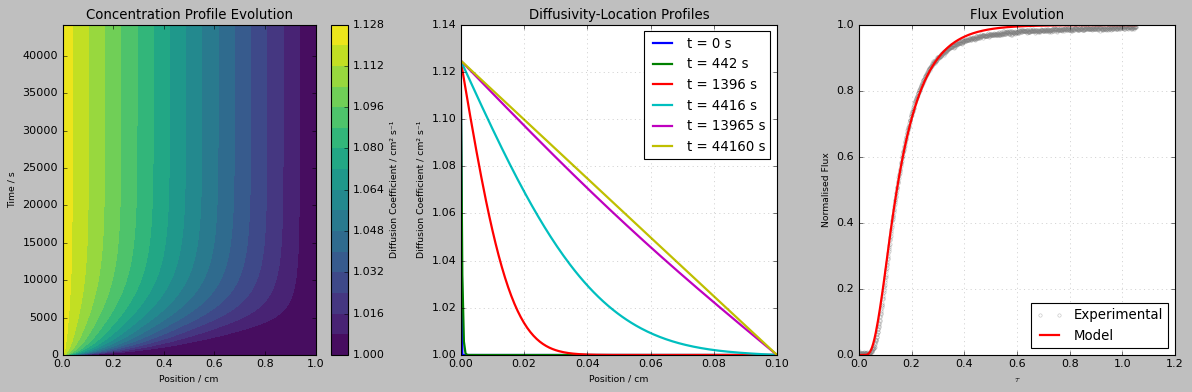

In [13]:
fit_results = fit_data_BFGS(processed_exp_data, initial_guess=5.0)
model, Dprime_df, flux_df, figures = manual_workflow(
    pressure=model.params.base.pressure,
    temperature=model.params.base.temperature,
    thickness=model.params.transport.thickness,
    diameter=model.params.transport.diameter,
    flowrate=model.params.transport.flowrate,
    D1_prime=fit_results[0],
    DT_0=model.params.transport.DT_0,
    experimental_data=processed_exp_data,
    simulation_params={
        'T': processed_exp_data['time'].max(),
        'X': 1.0,
        'dx': 0.005,
        },
    output_settings={
            'output_dir': 'outputs/fitting',
            'display_plots': True,
            'save_plots': False,
            'save_data': False,
            'plot_format': 'png',
            'data_format': 'csv'
    }
)